# Simple: get IBOV tickers and print a few

Run the code cell below. It imports `obter_tickers_yfinance` from `data/data.py`, tries to scrape, and falls back to two example tickers if scraping fails.

In [46]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Ensure repository root is on sys.path if notebook is inside 'notebooks/'
repo_root = Path.cwd()
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from data.data import obter_tickers_yfinance

# Use the function
tickers = obter_tickers_yfinance()


In [48]:
dados = yf.download(tickers, period="10y")
df = dados.stack(level=1)
df = df.reset_index().rename(columns={'level_1': 'Ticker'}) 


/tmp/ipykernel_4990/1365228440.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers, period="10y")
[                       0%                       ]

[*********************100%***********************]  82 of 82 completed
/tmp/ipykernel_4990/1365228440.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = dados.stack(level=1)


In [49]:
df = df[df['Ticker'] == 'ABEV3.SA'].reset_index(drop=True)

df = df[['Date', 'Close']]

df

Price,Date,Close
0,2015-12-14,12.170798
1,2015-12-15,12.035941
2,2015-12-16,12.231483
3,2015-12-17,12.238227
4,2015-12-18,12.002230
...,...,...
2487,2025-12-08,13.620000
2488,2025-12-09,13.640000
2489,2025-12-10,13.600000
2490,2025-12-11,13.780000


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

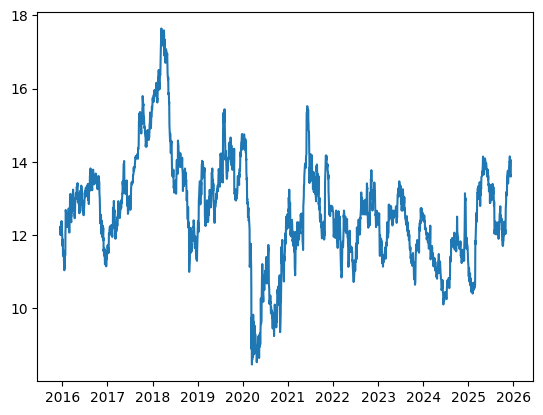

In [51]:
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df['Close'])

In [54]:
def scaler_data(stock):
    df = stock.fillna(method='ffill')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    stock['Close'] = scaler.fit_transform(np.array(stock['Close']).reshape(-1,1))

    return stock,scaler

df, scaler = scaler_data(df)

def load_data(stock, look_back):
    
    data_raw = stock.values # convert to numpy array
    data = []
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


look_back = 60 
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1946, 59, 2)
y_train.shape =  (1946, 2)
x_test.shape =  (486, 59, 2)
y_test.shape =  (486, 2)


/tmp/ipykernel_4990/2564503163.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = stock.fillna(method='ffill')


In [57]:
# Extract only the numerical values (second column) from x_train and y_train
x_train_values = x_train[:, :, 1].astype(float)
y_train_values = y_train[:, 1].astype(float)

# Extract test data similarly
x_test_values = x_test[:, :, 1].astype(float)
y_test_values = y_test[:, 1].astype(float)

# Convert to tensors
x_train = torch.from_numpy(x_train_values).type(torch.Tensor)
x_test = torch.from_numpy(x_test_values).type(torch.Tensor)
y_train = torch.from_numpy(y_train_values).type(torch.Tensor)
y_test = torch.from_numpy(y_test_values).type(torch.Tensor)

y_train.size(), x_train.size()

IndexError: index 1 is out of bounds for dimension 2 with size 1

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Loss for training/backprop
loss_mse = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# --- Regression metrics (torch tensors) ---
def rmse(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

loss_rmse = rmse

def mae(preds, targets):
    return torch.mean(torch.abs(preds - targets))

loss_mae = mae

def mape(preds, targets, eps=1e-8):
    return torch.mean(torch.abs((targets - preds) / (targets + eps))) * 100

loss_mape = mape


print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# Train model
#####################
num_epochs = 100
hist_mse = np.zeros(num_epochs)
hist_rmse = np.zeros(num_epochs)
hist_mae = np.zeros(num_epochs)
hist_mape = np.zeros(num_epochs)

# Extract only the numerical values (second column) from x_train and y_train
x_train_values = x_train[:, :, 1].reshape(x_train.shape[0], x_train.shape[1], 1).astype(float)
y_train_values = y_train[:, 1].reshape(-1, 1).astype(float)

# Convert to tensors
x_train_tensor = torch.tensor(x_train_values).float().to(device)
y_train_tensor = torch.tensor(y_train_values).float().to(device)

model = model.to(device)

for t in range(num_epochs):
    # Forward pass
    y_train_pred = model(x_train_tensor)

    mse_val = loss_mse(y_train_pred, y_train_tensor)
    rmse_val = loss_rmse(y_train_pred, y_train_tensor)
    mae_val = loss_mae(y_train_pred, y_train_tensor)
    mape_val = loss_mape(y_train_pred, y_train_tensor)
    
    if t % 10 == 0 and t != 0:
        print(f"Epoch {t} - MSE: {mse_val.item():.6f}, RMSE: {rmse_val.item():.6f}, MAE: {mae_val.item():.6f}, MAPE: {mape_val.item():.6f}")
    
    hist_mse[t] = mse_val.item()
    hist_rmse[t] = rmse_val.item()
    hist_mae[t] = mae_val.item()
    hist_mape[t] = mape_val.item()

    optimiser.zero_grad()

    # Backward pass
    mse_val.backward()
    # rmse_val.backward()
    # mae.backward()
    # mse_val.backward()


    # Update parameters
    optimiser.step()

Epoch 10 - MSE: 2.315274, RMSE: 1.521603, MAE: 1.127685, MAPE: 9.031478
Epoch 20 - MSE: 2.315080, RMSE: 1.521539, MAE: 1.129281, MAPE: 9.071031
Epoch 30 - MSE: 2.315138, RMSE: 1.521558, MAE: 1.129376, MAPE: 9.072927
Epoch 40 - MSE: 2.314827, RMSE: 1.521456, MAE: 1.128690, MAPE: 9.058176
Epoch 50 - MSE: 2.314816, RMSE: 1.521452, MAE: 1.128317, MAPE: 9.049125
Epoch 60 - MSE: 2.314817, RMSE: 1.521452, MAE: 1.128313, MAPE: 9.049012
Epoch 70 - MSE: 2.314802, RMSE: 1.521447, MAE: 1.128439, MAPE: 9.052219
Epoch 80 - MSE: 2.314804, RMSE: 1.521448, MAE: 1.128511, MAPE: 9.053978
Epoch 90 - MSE: 2.314803, RMSE: 1.521448, MAE: 1.128497, MAPE: 9.053661


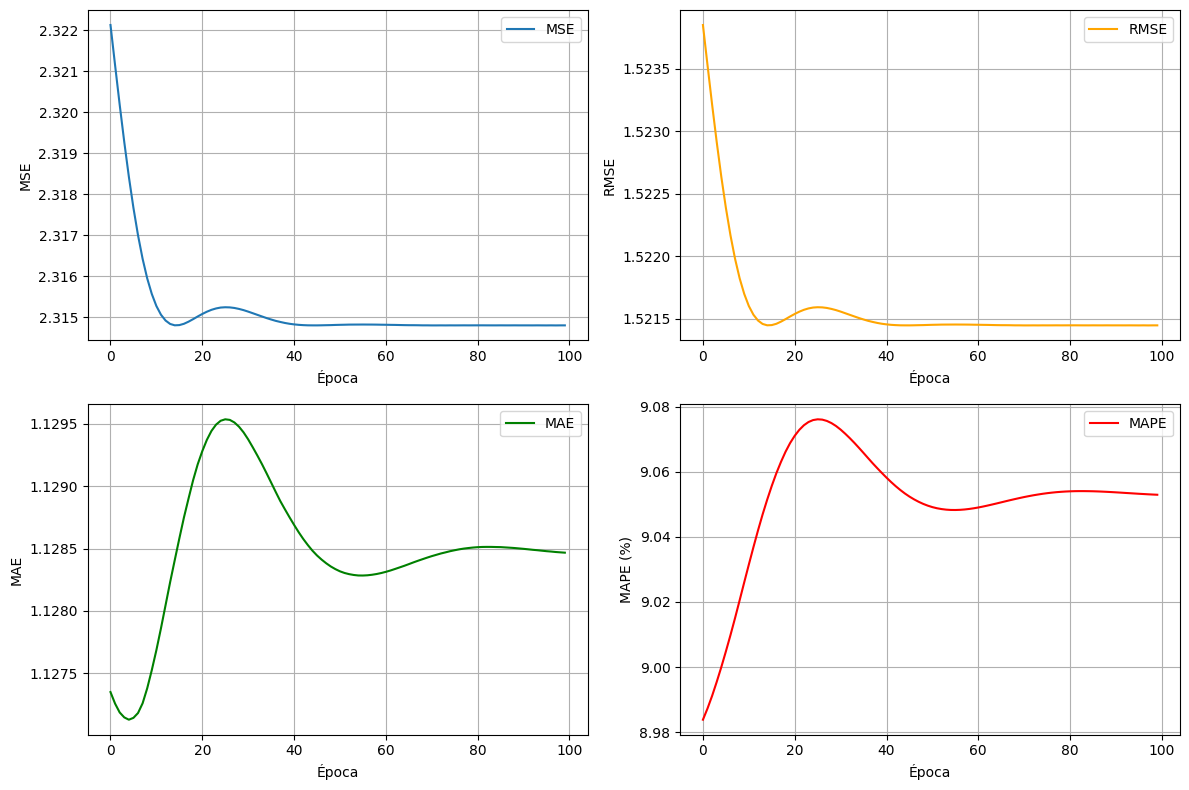

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(hist_mse, label="MSE")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(hist_rmse, label="RMSE", color='orange')
plt.xlabel("Época")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(hist_mae, label="MAE", color='green')
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(hist_mape, label="MAPE", color='red')
plt.xlabel("Época")
plt.ylabel("MAPE (%)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))